In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy as sc
from scipy.optimize import curve_fit # For fitting redshift distribution
from scipy.optimize import newton    # For finding roots to nonlinear equation
import scipy.integrate as integrate  # For integration

from PIL import Image
import pylab                         # For generating contours of image

# For auxiliary functions
import time
import sys

In [2]:
# Defining constants
c = 3e+8             # speed of light in m/s
AU = 1.5e+11       # astronomical unit = 149.6 million km
G = 6.67e-11      # Gravitational constant in Nm^2 kg^-2 == m^3 kg^-1 s^-2
pc = 3e+16       # parsec = 3.26 light years = 206,000 AU = 30.9 trillion km
Gpc = 1e9*pc
H_0 = 70e3           # Cosmological constant in m/(s Mpc)

# Defining radius and mass parameters of the system
M_sun = 2e+30    # in kg
M_earth = 6e+24 / M_sun # in solar masses
r_sun = 7e+8    # 696,340 km
r_earth = 6.4e+6/AU    # 6371 km, variable in AU

# Function to calculate location of L2, under reduced mass constraint
# R = distance between two masses M1, M2
# M1 = Mass of the larger object
# M2 = Mass of the smaller object
# https://en.wikipedia.org/wiki/Lagrange_point#L2
# Output: Langrange point distance in AU
def L2_point(R, M1, M2):
    return (R * (M2/(3*M1))**(1/3))

In [3]:
redshift = np.genfromtxt('redshift.csv',delimiter=',')

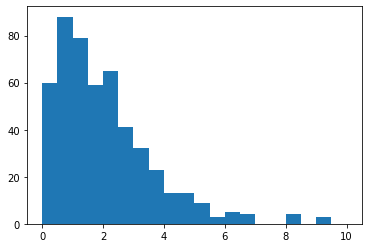

In [4]:
fig,ax = plt.subplots(1,1)
bins = np.linspace(0, 10, 21)
data_entries, bins = np.histogram(redshift, bins=bins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
ax.hist(redshift, bins = bins)
plt.show()

In [5]:
def fit_function(x, A, alpha):
    return (A * x * np.exp(-x*alpha))

In [6]:
popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[240,1.3])
print(popt)

[247.52234509   1.02585546]


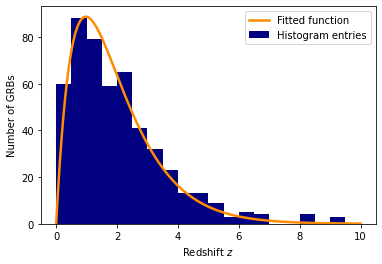

In [7]:
xspace = np.linspace(0, 10, 100000)
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
plt.plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Number of GRBs')
#plt.title(r'Exponential decay with gaussian peak')
plt.legend(loc='best')
#plt.savefig('fitted_distribution.png')
plt.show()

Refer [scipy tutorial](https://riptutorial.com/scipy/example/31081/fitting-a-function-to-data-from-a-histogram) for further information

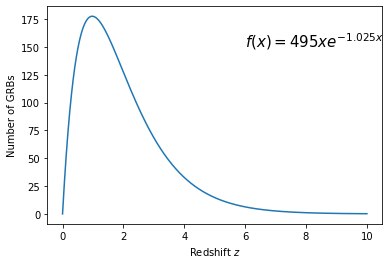

In [8]:
popt2 = np.array([247.52234509, 1.02585546])
popt2[0] /= 0.5
fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Number of GRBs')
plt.plot(xspace, fit_function(xspace,*popt2))
ax.text(6, 150, r'$f(x)=495x e^{-1.025x}$', fontsize=15)
#plt.savefig('distribution accounting for bin size.png')
plt.show()

In [9]:
Num_GRBs = lambda z_S: popt2[0] * z_S * np.exp(-popt2[1] * z_S) # Number of GRBs in +/- 0.05 for a given redshift
GRB_distribution = lambda z_S: popt2[0] * z_S * np.exp(-popt2[1] * z_S) / integrate.quad(Num_GRBs, 0, 10)[0] # GRB progenitor distribution as a function of redshift
Pr_GRB_zS = lambda z_S: integrate.quad(GRB_distribution, z_S - 0.25, z_S + 0.25) # Probability of selected GRB having z_S +/- 0.25 redshift

In [10]:
GRB_dbt_bin_size = 20
Pr_GRB_zS_numeric = np.zeros(GRB_dbt_bin_size)
for i in range(GRB_dbt_bin_size):
    Pr_GRB_zS_numeric[i] = Pr_GRB_zS(10/GRB_dbt_bin_size*i + 10/GRB_dbt_bin_size/2)[0]

In [11]:
Pr_GRB_zS_numeric

array([0.09418673, 0.17967312, 0.18139002, 0.15279999, 0.1179485 ,
       0.08646377, 0.06125533, 0.04235567, 0.02876067, 0.01925626,
       0.01274859, 0.00836301, 0.0054443 , 0.00352139, 0.00226507,
       0.00144999, 0.00092433, 0.00058706, 0.00037163, 0.00023457])

In [12]:
# Block to randomly sample points from GRB progenitor distribution
num_GRB_samples = 1000
l = []
for i in range(GRB_dbt_bin_size):
    for j in range(int(Pr_GRB_zS_numeric[i]*10000)): # 10000 multiplier covers 99.88% of the population space, 1000 -> 99.0%, 100000 -> 99.99%
        l.append(np.random.rand()/2 + i*10/GRB_dbt_bin_size)

In [13]:
GRB_list = np.array(l)
np.random.shuffle(GRB_list)

In [14]:
np.size(GRB_list)

9988

In [15]:
sim_GRB_list = np.zeros(num_GRB_samples)
size_GRB_list = np.shape(GRB_list)[0]
for i in range(num_GRB_samples):
    sim_GRB_list[i] = GRB_list[np.random.randint(size_GRB_list)]

In [16]:
np.min(sim_GRB_list),np.max(sim_GRB_list)

(0.00029458150878924894, 7.139679230513204)

$$D_S = \frac{z_sc}{H_0}$$
$$\theta_E = \sqrt{\frac{4GM}{c^2}\frac{1}{D}}$$
$$r_E = \theta_e D_L$$

In [17]:
c/(H_0*1e3)    # Above expression applicable for D_S ~ c/H_0

4.285714285714286

In [18]:
np.mean(sim_GRB_list*c/H_0*1e-3),np.max(sim_GRB_list*c/H_0*1e-3)

(8.743240680723424, 30.59862527362802)

In [19]:
# Function to calculate Einstein angle of a lensing system
# M = mass of the lens
# D = Effective lensing distance
# Output: Einstein angle in radians
def Einstein_angle(M, D):
    return np.sqrt((4*G*(M*M_sun))/(c**2 * (D*Gpc)))

num_samples = 1000

# Defining lensing system parameters (lengths)
DL = 1       # Distance between lens and observer in Gpc (simplifying assumption)
DS = sim_GRB_list*c/(H_0*1e3)# Distance between source and observer in Gpc
DLS = DS - DL    # Distance between lens and source in Gpc (assuming small deviation and flat universe)
D = DL*DS/DLS    # Effective lensing distance in Gpc
D = 1            # As given in the paper
print("D =",D)
x_lens = DL/DS   # Ratio of distance to lens to distance to source from observer (Range = [0,1])
#beta = np.linspace(-1e-28,1e-28,num_samples)    # Angular position of source in radians

# Defining lensing system parameters (times)
#t_var =          # Minimum variability time scale
#T_90 =           # Observed burst duration

# Defining lensing system parameters
#M = np.logspace(-16, -11, num_samples)    # Mass of lens in solar masses
M = 1e-13      # Mass of lens in solar masses (simplifying assumption)
z_L = 0          # Redshift of lens (simplifying approximation)
r_Sch = 1e-5 * M * c    # Schwarzschild radius in metres

# Derived parameters
theta_E = Einstein_angle(M, D)    # def Einstein_angle(M, D)
print("$theta_E$ =",theta_E)
r_E = theta_E * DL                # Einstein radius in Gpc

D = 1
$theta_E$ = 4.445555416701378e-18


(array([153., 247., 210., 157.,  93.,  55.,  40.,  21.,  15.,   9.]),
 array([1.26249218e-03, 3.06099877e+00, 6.12073505e+00, 9.18047133e+00,
        1.22402076e+01, 1.52999439e+01, 1.83596802e+01, 2.14194164e+01,
        2.44791527e+01, 2.75388890e+01, 3.05986253e+01]),
 <BarContainer object of 10 artists>)

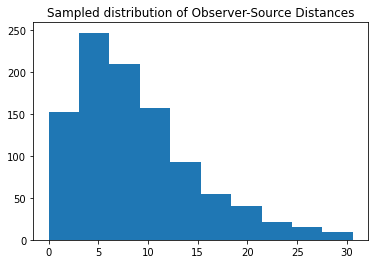

In [20]:
plt.title('Sampled distribution of Observer-Source Distances')
plt.hist(DS)

In [41]:
# Option 1 = Conservative
# Option 2 = Optimistic

option = 1

if option == 1:
    epsilon = 0.1
    nu = 1.2e+20    # 0.5 MeV
    NGRB = 10**3
    # Delta_r = np.array(((2*r_earth) / AU, L2_point(R, M_sun, M_earth), 2))     # distances in AU
                                                                           # def L2_point(R, M1, M2)
                                                                           # Delta_r[0] = 2*r_earth, Delta_r[1] = L2_point, Delta_r[2] = 2*AU
elif option == 2:
    epsilon = 0.01
    nu = 1.2e+21    # 5 MeV
    NGRB = 10**4
    # Delta_r = np.array(((2*r_earth) / AU, L2_point(R, M_sun, M_earth), 2))    # distances in AU
                                                                           # def L2_point(R, M1, M2)
                                                                           # Delta_r[0] = 2*r_earth, Delta_r[1] = L2_point, Delta_r[2] = 2*AU

In [22]:
r_S = 0.1*r_sun    # in metres
NGRB_small = 0.1*NGRB    # r_S < r_sun
NGRB_tiny = 0.03*NGRB    # r_S < 0.1*r_sun

### Appendix B: Finite source-size effect

In [23]:
# Function to calculate A_in
# Output: A_in
def A_in(u, delta):
    return (np.sqrt(1+ 4/(delta**2)) - 8 / (delta**3 * (delta**2 + 4)**1.5) * u**2/2 - 144 * (delta**4 + 2*delta**2 + 2) / (delta**5 * (delta**2 + 4)**3.5) * u**4/24)
    
# Function to calculate A_out
# Output: A_out
def A_out(u, delta):
    return ((2 + u**2) / (u*np.sqrt(u**2 + 4)) + (8*(u**2 + 1)) / (u**3 * (u**2 + 4)**2.5) * delta**2/2 + 48*(3*u**6 + 6*u**4 + 14*u**2 + 12) / (u**5 * (u**2 + 4)**4.5) * delta**4/24)

# Function to calculate the magnification of a finite sized circular source with constant surface brightness by a point-lens in the geometrical optics limit
# r_S = source size
# D = Effective lensing distance
# theta_E = Einstein angle
# u = Position of the source
# Output: Magnification
def finite_source_size_effect(r_S, D, theta_E, u):
    A = 0
    theta_S = r_S/(D * Gpc)
    delta = theta_S/theta_E

    if np.abs(u)<=np.abs(0.9*delta):
        A = A_in(u,delta)
        #print(1)
    elif np.abs(u)>=np.abs(1.1*delta):
        A = A_out(u,delta)
        #print(2)
    else:
        A = (A_out(1.1*delta, delta)*(u - 0.9*delta)/(0.2*delta) + A_in(0.9*delta, delta)*(1.1*delta - u)/(0.2*delta))
        #print(3)
    return A

### Appendix C: Computing optical depth and constraints

$$A_{1,2} > 1+\epsilon$$

In [218]:
# Simulating lens plane position of detectable dark matter

num_masses = 6
M = np.logspace(-12,-11,num_masses)
D = 1
theta_E = np.zeros(num_masses)
Delta_r = L2_point(AU/Gpc,1,M_earth)/2

z_S = 2
DS = z_S*c/(H_0*1e3)    # THIS IS WRONG
DS = 1
DL = 0.1*DS

num_sides = 200
arr_lens_plane_pos = np.zeros((num_masses,num_sides,num_sides))

beta1 = 0
beta2 = 0
u1 = 0
u2 = 0

count = np.zeros(num_masses)
pixel_length_x = np.zeros(num_masses)
pixel_length_y = np.zeros(num_masses)

# Calculating Einstein angles for each mass of lens (this can be done within the next loop if the plotting part is removed)

for k in range(num_masses):
    theta_E[k] = Einstein_angle(M[k],D)

# Plotting u vs theta_E and finding threshold of u

#tmp_x2 = np.arange(1000,5000,100)/1000
#tmp_y2 = np.zeros(40)
#for i2 in range(40):
#    tmp_y2[i2] = finite_source_size_effect(r_S, D, theta_E[19], tmp_x2[i2]) - (1 + epsilon)
#plt.plot(tmp_x2, tmp_y2)
#plt.show()

# Finding the threshold value of u=u_T for different masses at a given epsilon and theta_E

u_T = np.zeros(num_masses)

for k in range(num_masses):
    calc_threshold = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u) - 1 - epsilon
    u_T[k] = newton(calc_threshold, 2)

print('u_T =',u_T)                       # u_T is dimensionless
#'''
y = Gpc*DS*np.tan(u_T*theta_E[k])        # y in metres
print('y =',y)
Y = Delta_r + y                          # Y in metres
print('Y =',Y)
U_T = np.arctan(Y/(Gpc*DS))/theta_E[k]   # U_T is dimensionless
print('U_T =',U_T)
#'''
print(' ')

max_A = 0
max_u = 0

for k in range(num_masses):

    calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u)

    print('Iteration:',k)

    #pixel_length_x[k] = 2*Y[k] / num_sides
    #pixel_length_y[k] = 2*y[k] / num_sides
    pixel_length_x[k] = 20*theta_E[k]*DL/num_sides
    pixel_length_y[k] = 20*theta_E[k]*DL/num_sides

    for j in range(num_sides):

        for i in range(int(num_sides)):
    
            tmp_x = ((i - num_sides/2) + 0.5)*pixel_length_x[k]
            tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y[k]

            # Check if it is DL or DS (originally wrote DS, have taken temporary DL = 0.1*DS)
            #beta1 = np.arctan(np.sqrt((tmp_x - Delta_r)**2 + tmp_y**2)/(Gpc*DS))
            #beta2 = np.arctan(np.sqrt((tmp_x + Delta_r)**2 + tmp_y**2)/(Gpc*DS))
            beta1 = np.sqrt((tmp_x - Delta_r)**2 + tmp_y**2)/(DS)
            beta2 = np.sqrt((tmp_x + Delta_r)**2 + tmp_y**2)/(DS)

            u1 = beta1/theta_E[k]
            u2 = beta2/theta_E[k]

            A1 = calc_finite(u1)
            A2 = calc_finite(u2)

            if max_A < max(A1,A2):
                max_A = max(A1,A2)
            if max_u < max(u1,u2):
                max_u = max(u1,u2)+1e-15
            
            if A1 > (1 + epsilon) or A2 > (1 + epsilon):
                if np.abs(A1 - A2)/(A1 + A2) > epsilon / 2:
                    count[k]+=1
                    arr_lens_plane_pos[k,i,j]=np.abs(A1 - A2)/(A1 + A2)

        '''for i in range(int(num_sides*4/5),num_sides):

            tmp_x = ((i - num_sides/2) + 0.5)*pixel_length_x[k]
            tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y[k]

            beta1 = np.arctan(np.sqrt((tmp_x - Delta_r)**2 + tmp_y**2)/(Gpc*DS))
            beta2 = np.arctan(np.sqrt((tmp_x + Delta_r)**2 + tmp_y**2)/(Gpc*DS))

            u1 = beta1/theta_E[k]
            u2 = beta2/theta_E[k]

            A1 = calc_finite(u1)
            A2 = calc_finite(u2)
            
            if max_A < max(A1,A2):
                max_A = max(A1,A2)
            
            if A1 > (1 + epsilon) or A2 > (1 + epsilon):
                if np.abs(A1 - A2)/(A1 + A2) > epsilon / 2:
                    count[k]+=1
                    arr_lens_plane_pos[k,i,j]=max(A1,A2)'''
    
    print(max_A,max_u)
    max_A = 0
    max_u = 0
    
print(' ')
print(count)

u_T = [1.67815321 1.67645798 1.67538781 1.67471236 1.6742861  1.67401711]
y = [2.23809693e+09 2.23583605e+09 2.23440880e+09 2.23350798e+09
 2.23293949e+09 2.23258076e+09]
Y = [2.23809693e+09 2.23583605e+09 2.23440880e+09 2.23350798e+09
 2.23293949e+09 2.23258076e+09]
U_T = [1.67815321 1.67645798 1.67538781 1.67471236 1.6742861  1.67401711]
 
Iteration: 0
1.5615561012247299 2.946425156574996
Iteration: 1
2.5810179839239464 2.6050875185728906
Iteration: 2
8.752734046976977 2.33921890115582
Iteration: 3
24.02958072061203 2.1326218224617435
Iteration: 4
30.225613222811287 1.9723404788229282
Iteration: 5
38.007194143331674 1.8480782957128021
 
[21456. 28904. 32728. 34688. 35644. 36040.]


In [28]:
# Creates PIL image
img = Image.fromarray(np.uint8(np.transpose(arr_lens_plane_pos[10]) * 255) , 'L')
img.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.imshow(np.transpose(arr_lens_plane_pos[5]),label="1 unit = 0.1$R_E$")
plt.title("Plot 2D array")
plt.xlabel('$u_x(R_E)$')
plt.ylabel("$u_y(R_E)$")
plt.colorbar()
plt.legend()
plt.show()

No handles with labels found to put in legend.


In [198]:
np.max(arr_lens_plane_pos[10])

0.2087977606270368

In [52]:
# To save images of lens plane detectable dark matter positions

option_image = 0

if option_image == 0:
    k = 20
    image = Image.fromarray(np.uint8(np.transpose(arr_lens_plane_pos[k]) * 255), 'L')
    new_image = image.resize((int(200*pixel_length_x[k]/pixel_length_y[k]), 200))

    print(image.size)
    print(new_image.size)
    new_image.show()

if option_image == 1:
    for k in range(num_masses):
        image = Image.fromarray(np.uint8(np.transpose(arr_lens_plane_pos[k]) * 255), 'L')
        new_image = image.resize((int(200*pixel_length_x[k]/pixel_length_y[k]), 200))
        
        print(image.size)
        print(new_image.size)
        #new_image.show()
        new_image.save("./Simulation 2/Images/image_"+str(k)+".png", "PNG")

(200, 200)
(13637, 200)


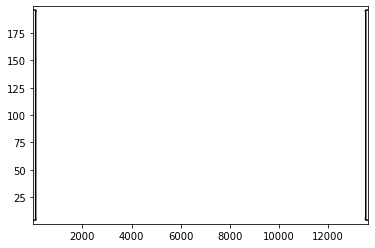

In [34]:
# To save contours of lens plane position of detectable dark matter

option_contour = 0

if option_contour == 0:
    k = 20
    image = Image.fromarray(np.uint8(np.transpose(arr_lens_plane_pos[k]) * 255), 'L')
    new_image = image.resize((int(200*pixel_length_x[k]/pixel_length_y[k]), 200))
    pylab.contour(new_image, levels=[245], colors='black', origin='image')

if option_contour == 1:
    for k in range(num_masses):
        image = Image.fromarray(np.uint8(np.transpose(arr_lens_plane_pos[k]) * 255), 'L')
        new_image = image.resize((int(200*pixel_length_x[k]/pixel_length_y[k]), 200))
        pylab.contour(new_image, levels=[245], colors='black', origin='image')
        pylab.savefig("./Simulation 2/Contours/contour_"+str(k)+".png")
        pylab.clf()

In [199]:
chi_S = DS*Gpc

V_L = np.zeros(num_masses)
for k in range(num_masses):
    sigma = lambda x_lens: (count[k]*pixel_length_x[k]*Gpc*pixel_length_y[k]*Gpc) * chi_S * x_lens**2
    V_L[k] = integrate.quad(sigma, 0, 1)[0]
print(V_L)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.16664252e+41 3.81630720e+42 8.14802804e+42
 1.46222442e+43 2.45625712e+43 4.00019351e+43 6.41031467e+43
 1.01619193e+44 1.59661610e+44 2.47211856e+44 3.60695263e+44
 5.14959573e+44 7.23129031e+44 9.89530263e+44 1.28222740e+45
 1.56353653e+45 1.86261973e+45 2.16837226e+45 2.46623038e+45
 2.71910382e+45 2.93583948e+45 3.13756800e+45 3.27003616e+45
 3.35979212e+45 3.42720378e+45 3.45656941e+45 3.55733333e+45
 3.38279603e+45 3.57424693e+45 3.68211976e+45 3.14233583e+45
 3.55733333e+45 3.38279603e+45 3.57424693e+45 5.66479963e+45
 4.48905119e+45 7.11466667e+45]


In [200]:
rho_crit_0 = (3 * ((H_0)**2)) / (8 * np.pi * G) * (pc*1e6) / M_sun * 1e9 # critical density in solar masses per Gpc^3
rho_crit_0 = 9.21e-27 / M_sun    # critical density in solar masses per m^3
Omega_DM = 0.26
f = np.logspace(-5,0,num_samples)
n = lambda f: rho_crit_0 * Omega_DM * f / M
print(n(1))

[1.19730000e-43 7.55445229e-44 4.76653715e-44 3.00748162e-44
 1.89759262e-44 1.19730000e-44 7.55445229e-45 4.76653715e-45
 3.00748162e-45 1.89759262e-45 1.19730000e-45 7.55445229e-46
 4.76653715e-46 3.00748162e-46 1.89759262e-46 1.19730000e-46
 7.55445229e-47 4.76653715e-47 3.00748162e-47 1.89759262e-47
 1.19730000e-47 7.55445229e-48 4.76653715e-48 3.00748162e-48
 1.89759262e-48 1.19730000e-48 7.55445229e-49 4.76653715e-49
 3.00748162e-49 1.89759262e-49 1.19730000e-49 7.55445229e-50
 4.76653715e-50 3.00748162e-50 1.89759262e-50 1.19730000e-50
 7.55445229e-51 4.76653715e-51 3.00748162e-51 1.89759262e-51
 1.19730000e-51 7.55445229e-52 4.76653715e-52 3.00748162e-52
 1.89759262e-52 1.19730000e-52]


In [201]:
tau = lambda f: n(f) * V_L

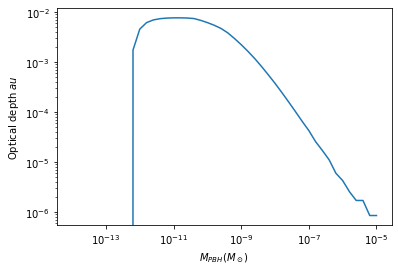

In [202]:
# Plot Optical Depth vs Mass of lens
plt.plot(M, tau(1))

plt.xlabel('$M_{PBH} (M_\odot)$')
plt.xscale('log')
plt.ylabel('Optical depth $\tau$')
plt.yscale('log')

plt.show()

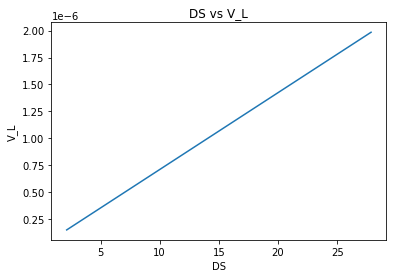

In [182]:
z_S2 = np.arange(7) + 0.5
DS2 = z_S2*c/(H_0*1e3)
chi_S2 = DS2*Gpc
V_L2 = np.zeros(7)

for k in range(7):
    sigma = lambda x_lens: (count[5]*pixel_length_x[5]*pixel_length_y[5]) * chi_S2[k] * x_lens**2
    V_L2[k] = integrate.quad(sigma, 0, 1)[0]

plt.title('DS vs V_L')
plt.xlabel('DS')
plt.ylabel('V_L')
plt.plot(DS2,V_L2)

In [208]:
f_final = np.zeros(num_masses)
for k in range(num_masses):
    tau = lambda f: n(f)[k] * V_L[k]
    
    P1 = lambda f: tau(f) * np.exp(-tau(f))
    P_null = lambda f: ((1 - P1(f))**(1000/1000))**1000
    
    num_f = 1000
    f = np.logspace(-5,0,num_f)
    #print(f)
    y_P = np.zeros(num_f)
    y_2 = np.ones(num_f)*0.05
    for i in range(num_f):
        y_P[i] = P_null(f[i])
    '''
    plt.title(M[k])
    plt.xlabel('f')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('P_null')
    plt.plot(f,y_2)
    plt.plot(f,y_P)
    plt.show()
    '''
    for l in range(num_f):
        if y_P[l] < 0.05:
            f_final[k] = f[l]
            break

print(f_final)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.6604194  0.48942899
 0.4311562  0.40701425 0.3977403  0.39318288 0.39318288 0.3977403
 0.40701425 0.44120929 0.48942899 0.54921165 0.63797668 0.78504562
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


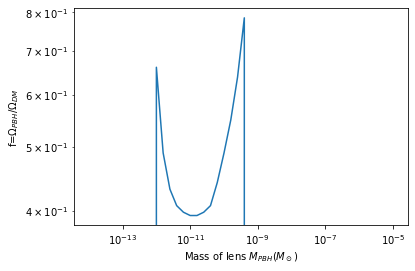

In [206]:
# Plot f vs Mass of lens

plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-3,1e-2)
plt.xlabel('Mass of lens $M_{PBH}(M_\odot)$')
plt.ylabel('f=$\Omega_{PBH}/\Omega_{DM}$')
plt.plot(M,f_final)

0


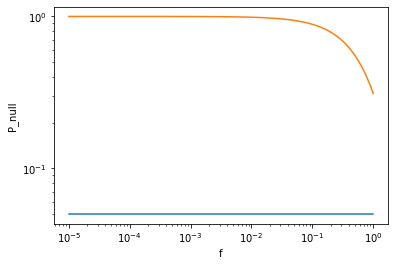

In [43]:
tau = lambda f: n(f)[20] * V_L[20]
P1 = lambda f: tau(f) * np.exp(-tau(f))
P_null = lambda f: ((1 - P1(f))**(NGRB_tiny/1000))**1000

f = np.logspace(-5,0,100)

f_null = 0
#print(f)
y_P = np.zeros(100)
y_2 = np.ones(100)*0.05
for i in range(100):
    y_P[i] = P_null(f[i])
for i in range(100):
    if y_P[i] < 0.05:
        f_null = f[i]
        break
print(f_null)
plt.xlabel('f')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('P_null')
plt.plot(f,y_2)
plt.plot(f,y_P)

In [166]:
def tmp_func(delta, u):
    A = 0
    if np.abs(u)<=np.abs(0.9*delta):
        A = A_in(u,delta)
        #print(1)
    elif np.abs(u)>=np.abs(1.1*delta):
        A = A_out(u,delta)
        #print(2)
    else:
        A = (A_out(1.1*delta, delta)*(u - 0.9*delta)/(0.2*delta) + A_in(0.9*delta, delta)*(1.1*delta - u)/(0.2*delta))
        #print(3)
    return A

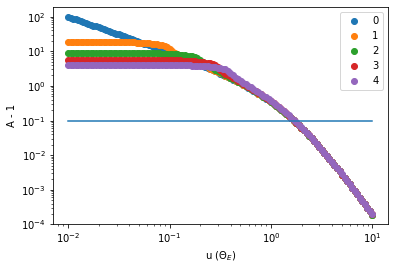

In [167]:
tmp_u = np.logspace(-2,1,121)
    
plt.plot(tmp_u, np.ones(121)*epsilon)
    
for j in range(5):
    delta = j/10


    tmp_A = np.zeros(121)
    for i in range(121):
        tmp_A[i] = tmp_func(delta,tmp_u[i])

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('u $(\Theta_E)$')
    plt.ylabel('A - 1')
    plt.scatter(tmp_u,tmp_A -1,label=str(j))
    plt.legend()